prepping the code

In [4]:
from itertools import count
import numpy as np
import pandas as pd
import psycopg2
import dotenv
import os
from matplotlib import animation
from matplotlib import pyplot as plt
from mplsoccer import Pitch
from scipy.interpolate import interp1d

dotenv.load_dotenv()

PG_PASSWORD = os.getenv("PG_PASSWORD")
PG_USER = os.getenv("PG_USER")
PG_HOST = os.getenv("PG_HOST")
PG_PORT = os.getenv("PG_PORT")
PG_DATABASE = os.getenv("PG_DB")

conn = psycopg2.connect(
    host=PG_HOST,
    database=PG_DATABASE,
    user=PG_USER,
    password=PG_PASSWORD,
    port=PG_PORT,
    sslmode="require",
)


matches_1 = """
SELECT  
    me.*, 
    et.name AS event_name,  
    et.description AS event_description  
FROM public.matchevents me
INNER JOIN public.eventtypes et USING(eventtype_id)
INNER JOIN public.matches m USING(match_id)
WHERE m.match_id = '5pcyhm34h5c948yji4oryevpw'
"""

df_matches = pd.read_sql_query(matches_1,conn)


# Convert timedelta-like format to seconds
# df_matches["timestamp"] = df_matches["timestamp"].astype(str).str.extract(r'(\d+\.\d+)')[0].astype(float)
# df_matches["end_timestamp"] = df_matches["end_timestamp"].astype(str).str.extract(r'(\d+\.\d+)')[0].astype(float)

# # Check the result
# print(df_matches[["timestamp", "end_timestamp"]].head())


df_matches.head()

,match_id,event_id,eventtype_id,result,success,period_id,timestamp,end_timestamp,ball_state,ball_owning_team,team_id,player_id,x,y,end_coordinates_x,end_coordinates_y,receiver_player_id,event_name,event_description
0,5pcyhm34h5c948yji4oryevpw,2704102295,e319ac55-ffaf-4e6d-87f7-7601d91bcd33,COMPLETE,True,1,0 days 00:00:00.087000,0 days 00:00:01.627000,alive,cyrrlv6l1onld5x247w1q1jlr,cyrrlv6l1onld5x247w1q1jlr,6g9x1y7xmjzwhk646v1iyuup5,50.0,50.0,37.0,49.3,cfxzvlgvt9jj17qxq41t9sxcl,PASS,StatsPerform/Opta event type: PASS
1,5pcyhm34h5c948yji4oryevpw,2704102881,e319ac55-ffaf-4e6d-87f7-7601d91bcd33,COMPLETE,True,1,0 days 00:00:01.627000,0 days 00:00:04.178000,alive,cyrrlv6l1onld5x247w1q1jlr,cyrrlv6l1onld5x247w1q1jlr,cfxzvlgvt9jj17qxq41t9sxcl,39.1,48.0,32.3,38.9,2ky2kn7gpjorkyg9zyg68pk6i,PASS,StatsPerform/Opta event type: PASS
2,5pcyhm34h5c948yji4oryevpw,2704102909,e319ac55-ffaf-4e6d-87f7-7601d91bcd33,INCOMPLETE,False,1,0 days 00:00:04.178000,NaT,alive,cyrrlv6l1onld5x247w1q1jlr,cyrrlv6l1onld5x247w1q1jlr,2ky2kn7gpjorkyg9zyg68pk6i,36.3,36.4,69.7,16.7,None,PASS,StatsPerform/Opta event type: PASS
3,5pcyhm34h5c948yji4oryevpw,2704103595,2464af85-9671-4c4c-90ae-100af0a5e2ee,WON,True,1,0 days 00:00:06.575000,NaT,alive,cyrrlv6l1onld5x247w1q1jlr,bw9wm8pqfzcchumhiwdt2w15c,9fvwcsajeousbo5o0e84cj2sp,22.0,91.6,NaN,NaN,None,DUEL,StatsPerform/Opta event type: DUEL
4,5pcyhm34h5c948yji4oryevpw,2704103597,2464af85-9671-4c4c-90ae-100af0a5e2ee,LOST,False,1,0 days 00:00:06.576000,NaT,alive,cyrrlv6l1onld5x247w1q1jlr,cyrrlv6l1onld5x247w1q1jlr,8ozlo6qrdavr86guhclwvh84q,78.0,8.4,NaN,NaN,None,DUEL,StatsPerform/Opta event type: DUEL


testing out the model

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# Convert categorical features into numeric values (for example, 'event_name')
df_matches['event_name'] = df_matches['event_name'].astype('category').cat.codes
df_matches['event_description'] = df_matches['event_description'].astype('category').cat.codes

# Select your features (X) and target variable (y)
X = df_matches[['event_name', 'event_description', 'x', 'y']]  # Add more features if needed
y = df_matches['event_name']  # Assuming 'match_id' is the target you want to predict

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)  # You can tune n_neighbors based on performance
knn.fit(X_train_scaled, y_train)

# Make predictions and evaluate the model
y_pred = knn.predict(X_test_scaled)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.97      1.00      0.99        35
           1       0.00      0.00      0.00         1
           2       0.75      0.82      0.78        11
           3       0.80      0.84      0.82        19
           5       0.33      0.60      0.43         5
           6       0.60      0.30      0.40        10
           8       0.00      0.00      0.00         3
           9       0.50      0.50      0.50         2
          10       0.33      1.00      0.50         1
          11       0.75      0.86      0.80         7
          12       0.00      0.00      0.00         2
          14       1.00      1.00      1.00         1
          16       1.00      1.00      1.00         1
          17       1.00      0.57      0.73         7
          18       0.75      1.00      0.86         3
          19       0.00      0.00      0.00         5
          20       0.20      0.17      0.18         6
          21       0.90    

In [6]:
from sklearn.model_selection import cross_val_score

# Use cross-validation to find the optimal K value
k_range = range(1, 21)  # Try K values from 1 to 20
cv_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

best_k = k_range[np.argmax(cv_scores)]
print(f"Best K: {best_k}")


Best K: 1


In [7]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# Select your features (X) and target variable (y)
X = df_matches[['event_name', 'event_description', 'x', 'y']]  # Add more features if needed
y = df_matches['x']  # Assuming 'goals_scored' is the target you want to predict

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply KNN regressor
knn = KNeighborsRegressor(n_neighbors=5)  # You can tune n_neighbors based on performance
knn.fit(X_train_scaled, y_train)

# Make predictions and evaluate the model
y_pred = knn.predict(X_test_scaled)
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")


Mean Squared Error: 4.261345911949684


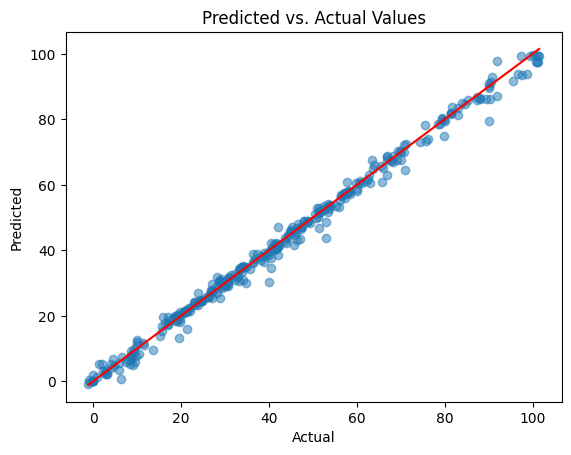

In [9]:
import matplotlib.pyplot as plt 
from sklearn.inspection import DecisionBoundaryDisplay

import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='-', color='red')  
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs. Actual Values")
plt.show()
